In [97]:
import yfinance as yf

# Download stock data (e.g., Apple stock)
df = yf.download('AAPL', start='2015-01-01', end='2020-01-01')

# Add additional technical indicators if needed (e.g., Moving Averages)
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# Only use relevant columns (for example, Close prices and SMAs)
df = df[['Close', 'SMA_10', 'SMA_50']].dropna()


[*********************100%***********************]  1 of 1 completed


In [98]:
df

Price,Close,SMA_10,SMA_50
Ticker,AAPL,,
Date,,,
2015-03-16,31.237499,31.444750,29.91460
2015-03-17,31.760000,31.386750,30.00315
2015-03-18,32.117500,31.385000,30.11425
2015-03-19,31.875000,31.412250,30.22045
2015-03-20,31.475000,31.394750,30.31120
...,...,...,...
2019-12-24,71.067497,69.627998,65.16060
2019-12-26,72.477501,70.106499,65.43355


In [2]:
import gym
from gym import spaces
import numpy as np
import pandas as pd

class StockTradingEnv(gym.Env):
    def __init__(self, df, window_size=10):
        super(StockTradingEnv, self).__init__()

        self.df = df  # The dataframe contains historical stock prices
        self.window_size = window_size  # Number of previous days to observe
        self.current_step = 0
        self.max_steps = len(df)  # Length of the data
        self.action_space = spaces.Discrete(3)  # Buy, sell, hold
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(self.window_size, len(df.columns)), dtype=np.float32)

        self.initial_balance = 1000  # Initial cash balance
        self.balance = self.initial_balance
        self.stock_held = 0
        self.total_balance = self.balance + self.stock_held  # Total value (cash + stock value)

    def reset(self):
        self.current_step = self.window_size
        self.balance = self.initial_balance
        self.stock_held = 0
        self.total_balance = self.balance + self.stock_held
        return self._get_observation()

    def _get_observation(self):
        # Get the last 'window_size' stock data points (features can include price, moving averages, etc.)
        obs = self.df.iloc[self.current_step - self.window_size:self.current_step].values
        return obs

    def step(self, action):
        # Get the current stock price
        #print(self.df.iloc[self.current_step])
        current_price = self.df.iloc[self.current_step]['Close'][0]

        transaction_cost = 0.001  # 0.1% per transaction

        # Define actions
        if action == 0:  # Buy
            #print(self.balance)
            #print(current_price)
            if self.balance >= current_price:  # Check if we have enough balance to buy
                self.stock_held += 1
                self.balance -= current_price * (1 + transaction_cost)
        elif action == 1:  # Sell
            if self.stock_held > 0:  # Check if we have stocks to sell
                self.stock_held -= 1
                self.balance += current_price * (1 - transaction_cost)
        # If action is 2, we hold (no change in portfolio)

        # Update the total balance (cash + value of stocks)
        self.total_balance = self.balance + self.stock_held * current_price

        # Calculate reward (change in portfolio value)
        reward = self.total_balance - self.initial_balance  # Net change in value

        # Move to the next timestep
        self.current_step += 1

        # Check if we are done (i.e., if we've reached the end of the data)
        done = self.current_step >= self.max_steps

        # Return the next observation, reward, and done flag
        next_state = self._get_observation()
        return next_state, reward, done, {}

    def render(self):
        print(f"Step: {self.current_step}, Balance: {self.balance}, Stock held: {self.stock_held}, Total Balance: {self.total_balance}")


In [5]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# Wrap your environment in a vectorized environment (required by Stable-Baselines3)
env = DummyVecEnv([lambda: StockTradingEnv(df)])

# Define the PPO model
#model = PPO('MlpPolicy', env, verbose=1)
model = PPO('MlpPolicy', env, verbose=1)

# Train the model
model.learn(total_timesteps=1000)

/opt/anaconda3/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device


/var/folders/nx/r3ldwknn2px8dwls09w7zhs40000gn/T/ipykernel_6321/2353274037.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_price = self.df.iloc[self.current_step]['Close'][0]


-----------------------------
| time/              |      |
|    fps             | 3447 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------


In [7]:
# Reset the environment to start a new episode
state = env.reset()

done = False
total_reward = 0

while not done:
    # Get the action from the trained PPO model
    action, _ = model.predict(state)

    # Take the action in the environment
    state, reward, done, _ = env.step(action)

    # Accumulate the total reward
    total_reward += reward

    # Render the environment
    env.render()

print(f"Total Reward: {total_reward}")


/var/folders/nx/r3ldwknn2px8dwls09w7zhs40000gn/T/ipykernel_6321/2353274037.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_price = self.df.iloc[self.current_step]['Close'][0]
/opt/anaconda3/lib/python3.12/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:243: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


Total Reward: [327192.38]


In [11]:
import pandas as pd
import numpy as np

dp = pd.read_csv("dataset/AAPL_stock_data.csv", index_col = 0)
dp['BarDateTime'] = pd.to_datetime(dp['BarDateTime'], utc = True).dt.strftime('%Y-%m-%d %H:%M:%S')
do = pd.read_csv("dataset/AAPL_p_1min_data_v2.csv", index_col = 0)
do = do[do['option_p'] != 0]
do['time'] = pd.to_datetime(do['time']).dt.strftime('%Y-%m-%d %H:%M:%S')

df = pd.merge(do, dp, left_on = 'time', right_on = 'BarDateTime')

df_small = df.loc[df.groupby('time')['moneyness'].apply(lambda x: x.abs().idxmin())]

d_one_day_after = pd.DataFrame(columns = df.columns)

for i in range(len(df_small) - 1):
    d_one_day_after = pd.concat([d_one_day_after, df[(df['time'] == df_small.iloc[i + 1,:]['time']) & (df['strike'] == df_small.iloc[i,:]['strike']) & (df['expiry'] == df_small.iloc[i,:]['expiry'])]])

option_price_one_day_after =  d_one_day_after['option_p'].reset_index(drop = True)
option_price_one_day_after.name = 'option_p_old'

#df_small = pd.concat([df_small.iloc[:-1,:].reset_index(drop = True), option_price_one_day_after.reset_index(drop = True)], axis = 1)
#df_small.to_csv('AAPL_RL_test.csv', index = False)
#df_small.to_csv('AAPL_RL_test.csv', index = False)

/var/folders/nx/r3ldwknn2px8dwls09w7zhs40000gn/T/ipykernel_9495/3882957503.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  d_one_day_after = pd.concat([d_one_day_after, df[(df['time'] == df_small.iloc[i + 1,:]['time']) & (df['strike'] == df_small.iloc[i,:]['strike']) & (df['expiry'] == df_small.iloc[i,:]['expiry'])]])


In [15]:
pd.concat([df_small.iloc[1:,:].reset_index(drop = True), option_price_one_day_after.reset_index(drop = True)], axis = 1)

,time,ticker,price,option_type,strike,expiry,option_p,high,low,ttm,...,OpenAskPrice,OpenBidPrice,HighAskPrice,HighBidPrice,LowAskPrice,LowBidPrice,CloseAskPrice,CloseBidPrice,Volume,option_p_old
0,2024-01-02 10:35:00,AAPL,188.0300,P,187.5,2024-01-05 23:59:59,1.305,1.460,1.280,0.009751,...,190.10,190.01,190.10,190.08,190.10,190.00,190.10,190.05,188,1.305
1,2024-01-02 10:40:00,AAPL,187.1300,P,187.5,2024-01-12 23:59:59,2.540,2.585,2.330,0.028919,...,190.24,190.10,190.24,190.15,190.24,190.10,190.24,190.15,5,1.740
2,2024-01-02 10:45:00,AAPL,186.0140,P,185.0,2024-01-05 23:59:59,1.165,1.165,1.055,0.009732,...,190.14,190.10,190.14,190.12,190.13,190.10,190.14,190.12,386,3.175
3,2024-01-02 10:50:00,AAPL,186.2218,P,185.0,2024-01-26 23:59:59,2.855,2.900,2.760,0.067256,...,190.15,190.01,190.15,190.03,190.15,190.01,190.15,190.01,17,1.085
4,2024-01-02 10:55:00,AAPL,186.2576,P,187.5,2024-01-12 23:59:59,3.020,3.025,2.940,0.028891,...,190.09,190.01,190.15,190.05,190.07,190.01,190.15,190.01,377,2.805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452,2024-01-26 16:50:00,AAPL,192.1250,P,192.5,2024-01-26 23:59:59,0.395,0.435,0.375,0.000818,...,194.12,194.11,194.18,194.17,194.08,194.07,194.17,194.16,21638,0.195
1453,2024-01-26 16:55:00,AAPL,192.2983,P,192.5,2024-01-26 23:59:59,0.215,0.375,0.140,0.000809,...,193.96,193.95,193.98,193.97,193.93,193.92,193.97,193.96,27395,0.195
1454,2024-01-26 17:00:00,AAPL,192.1200,P,192.5,2024-01-26 23:59:59,0.195,0.195,0.195,0.000799,...,194.05,194.04,194.05,194.04,193.97,193.96,194.00,193.99,25443,0.195
1455,2024-01-26 17:05:00,AAPL,192.2100,P,192.5,2024-01-26 23:59:59,0.195,0.195,0.195,0.000790,...,193.95,193.94,193.98,193.97,193.93,193.92,193.95,193.94,18783,NaN


,time,ticker,price,option_type,strike,expiry,option_p,high,low,ttm,...,OpenAskPrice,OpenBidPrice,HighAskPrice,HighBidPrice,LowAskPrice,LowBidPrice,CloseAskPrice,CloseBidPrice,Volume,option_p_next
0,2024-01-02 10:35:00,AAPL,188.0300,P,187.5,2024-01-05 23:59:59,1.305,1.460,1.280,0.009751,...,190.10,190.01,190.10,190.08,190.10,190.00,190.10,190.05,188,1.305
1,2024-01-02 10:40:00,AAPL,187.1300,P,187.5,2024-01-12 23:59:59,2.540,2.585,2.330,0.028919,...,190.24,190.10,190.24,190.15,190.24,190.10,190.24,190.15,5,1.740
2,2024-01-02 10:45:00,AAPL,186.0140,P,185.0,2024-01-05 23:59:59,1.165,1.165,1.055,0.009732,...,190.14,190.10,190.14,190.12,190.13,190.10,190.14,190.12,386,3.175
3,2024-01-02 10:50:00,AAPL,186.2218,P,185.0,2024-01-26 23:59:59,2.855,2.900,2.760,0.067256,...,190.15,190.01,190.15,190.03,190.15,190.01,190.15,190.01,17,1.085
4,2024-01-02 10:55:00,AAPL,186.2576,P,187.5,2024-01-12 23:59:59,3.020,3.025,2.940,0.028891,...,190.09,190.01,190.15,190.05,190.07,190.01,190.15,190.01,377,2.805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452,2024-01-26 16:50:00,AAPL,192.1250,P,192.5,2024-01-26 23:59:59,0.395,0.435,0.375,0.000818,...,194.12,194.11,194.18,194.17,194.08,194.07,194.17,194.16,21638,0.195
1453,2024-01-26 16:55:00,AAPL,192.2983,P,192.5,2024-01-26 23:59:59,0.215,0.375,0.140,0.000809,...,193.96,193.95,193.98,193.97,193.93,193.92,193.97,193.96,27395,0.195
1454,2024-01-26 17:00:00,AAPL,192.1200,P,192.5,2024-01-26 23:59:59,0.195,0.195,0.195,0.000799,...,194.05,194.04,194.05,194.04,193.97,193.96,194.00,193.99,25443,0.195
1455,2024-01-26 17:05:00,AAPL,192.2100,P,192.5,2024-01-26 23:59:59,0.195,0.195,0.195,0.000790,...,193.95,193.94,193.98,193.97,193.93,193.92,193.95,193.94,18783,NaN


In [33]:
import pandas as pd
import numpy as np

df = pd.read_csv("AAPL_RL_test.csv", index_col = 0)
df = df.drop(['ticker', 'Ticker', 'expiry', 'option_type', 'BarDateTime'], axis = 1)
df = df.dropna()
df

,price,strike,option_p,high,low,ttm,moneyness,riskfree,OpenAskPrice,OpenBidPrice,HighAskPrice,HighBidPrice,LowAskPrice,LowBidPrice,CloseAskPrice,CloseBidPrice,Volume,option_p_next
time,,,,,,,,,,,,,,,,,,
2024-01-02 10:35:00,188.0300,187.5,1.305,1.460,1.280,0.009751,0.5300,5.28,190.10,190.01,190.10,190.08,190.10,190.00,190.10,190.05,188,1.305
2024-01-02 10:40:00,187.1300,187.5,2.540,2.585,2.330,0.028919,-0.3700,5.28,190.24,190.10,190.24,190.15,190.24,190.10,190.24,190.15,5,1.740
2024-01-02 10:45:00,186.0140,185.0,1.165,1.165,1.055,0.009732,1.0140,5.28,190.14,190.10,190.14,190.12,190.13,190.10,190.14,190.12,386,3.175
2024-01-02 10:50:00,186.2218,185.0,2.855,2.900,2.760,0.067256,1.2218,5.28,190.15,190.01,190.15,190.03,190.15,190.01,190.15,190.01,17,1.085
2024-01-02 10:55:00,186.2576,187.5,3.020,3.025,2.940,0.028891,-1.2424,5.28,190.09,190.01,190.15,190.05,190.07,190.01,190.15,190.01,377,2.805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-26 16:40:00,192.0850,192.5,0.455,0.485,0.420,0.000837,-0.4150,5.27,194.04,194.03,194.08,194.07,193.98,193.97,194.06,194.05,50763,0.395
2024-01-26 16:45:00,192.0499,192.5,0.435,0.490,0.365,0.000828,-0.4501,5.27,193.98,193.97,194.05,194.04,193.96,193.95,194.00,193.99,38496,0.215
2024-01-26 16:50:00,192.1250,192.5,0.395,0.435,0.375,0.000818,-0.3750,5.27,194.12,194.11,194.18,194.17,194.08,194.07,194.17,194.16,21638,0.195


In [19]:
import gym
from gym import spaces

In [19]:
spaces.Box(low = 0, high = np.inf)

Box(0.0, inf, (1,), float32)

In [289]:


class StockHedgingEnv(gym.Env):
    def __init__(self, df, window_size=10, render_mode='human'):
        super(StockHedgingEnv, self).__init__()
        self.render_mode = render_mode
        self.df = df  # The dataframe contains historical stock prices
        self.window_size = window_size  # Number of previous days to observe
        self.current_step = 0
        self.max_steps = len(df)  # Length of the data
        #self.action_space = spaces.Discrete(3)  # Buy, sell, hold
        self.action_space = spaces.Box(low = 1, high = 10000) # 
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.window_size, len(df.columns)), dtype=np.float32)
        self.performance = []
        #self.initial_balance = 1000  # Initial cash balance
        #self.balance = self.initial_balance
        self.stock_held = 1
        self.option_held = 0
        self.balance = 0
        self.vol = 0
        #self.stock_held = 0
        #self.total_balance = self.balance + self.stock_held  # Total value (cash + stock value)

    def reset(self):
        #self.stock_held = 1
        self.current_step = self.window_size
        self.stock_held = 1
        self.option_held = 0
        self.balance = 0
        self.performance = []
        #self.balance = self.initial_balance
        #self.stock_held = 0
        #self.total_balance = self.balance + self.stock_held
        return self._get_observation()

    def _get_observation(self):
        # Get the last 'window_size' stock data points (features can include price, moving averages, etc.)
        obs = self.df.iloc[self.current_step - self.window_size:self.current_step].values
        return obs

    def step(self, action):
        # Get the current stock price
        #print(self.df.iloc[self.current_step])
        #print(self.df.iloc[self.current_step]['price'])
        p_now = self.df.iloc[self.current_step]['price']
        p_prev = self.df.iloc[self.current_step - 1]['price']
        old_o_p_prev = self.df.iloc[self.current_step - 1]['option_p']
        old_o_p_now = self.df.iloc[self.current_step]['option_p_next']
        port_value_change = p_now - p_prev - self.option_held * (old_o_p_now - old_o_p_prev)
        self.balance += port_value_change
        if isinstance(self.balance, np.ndarray):
            self.balance = self.balance[0]
        elif isinstance(self.balance, np.float64):
            self.balance = self.balance
        self.option_held = action
        #print(self.balance)
        self.performance.append(self.balance)
        #print(self.performance)
        self.vol = np.std(self.performance)
        print(self.vol)
        reward = port_value_change - 0.5 * self.vol ** 2
        transaction_cost = 0  # 0.1% per transaction
        # Move to the next timestep
        self.current_step += 1

        # Check if we are done (i.e., if we've reached the end of the data)
        done = self.current_step >= self.max_steps

        # Return the next observation, reward, and done flag
        next_state = self._get_observation()
        return next_state, reward, done, {}

    def render(self, mode):
        render_mode = mode
        #print(f"Step: {self.current_step}, Balance: {self.balance}, Option held: {self.option_held}")
        return(self.balance)

/opt/anaconda3/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
0.0
0.4699999802112558
0.5723891362648774
0.5463614867056669
0.5127279140921063
0.5849641605770459
0.5712744369182755
0.5504819565252653
0.5594620169695866
0.605414557880794
0.6505708186918928
0.6452066886603408
0.6540773303410267
0.7258740828862482
0.7904394683457834
0.8298110969480093
0.8710608548752853
0.8868208230194565
0.8801153599795815
0.8850428470951248
0.8799164904601376
0.8745417339173975
0.8677286102357931
0.8570469148673124
0.857933327891879
0.8431458931766749
0.840989767183879
0.8461544710067257
0.8396453214790838
0.8283369326658494
0.8203629090889165
0.8142630776926413
0.8083036417180206
0.808074096027332
0.8056458539248783
0.8128214320635331
0.8205256009551022
0.8342776763314742
0.8428509347847472
0.8449969150990548
0.8516465798588352
0.8737144098969939
0.8969270989119092
0.9205554140975859
0.9423738064102816
0.9769783712332144
1.010748213877964
1.0576196805162466
1.1125015390505344
1.140433590356408
1.176338907872756
1.2023570660213463
1.223802507486050

/opt/anaconda3/lib/python3.12/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:243: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


2.4282983498045123
2.435839774110242
2.442402236624709
2.4497281197000462
2.4570862185474063
2.463482646242219
2.469345975094329
2.4749707649620225
2.479290530463412
2.4839259167706214
2.4891971090949663
2.494867707539936
2.5015752887152045
2.5082016946620493
2.5148971522023964
2.521385619660299
2.5274530699732174
2.5331876025617617
2.537808855012729
2.542303367340032
2.547127528796397
2.551866117872823
2.556583923874343
2.5611272843998387
2.565753243970644
2.5706649240959405
2.576088443272219
2.580675308398898
2.5855484241815136
2.5898289643614505
2.5943080154271465
2.5986366894382487
2.6029403353510054
2.608065265414393
2.6129912098562924
2.6179981464226474
2.6231138643936984
2.628084207035852
2.6328083396603823
2.637918701502272
2.6431529482167346
2.6484812118688765
2.6541374461853926
2.6595584297161383
2.664841474716532
2.6701676646384307
2.6756354203569708
2.6811113336989965
2.686636230142644
2.6920999414768665
2.6973628909729213
2.7019873034905264
2.7058166726116264
2.70921661082

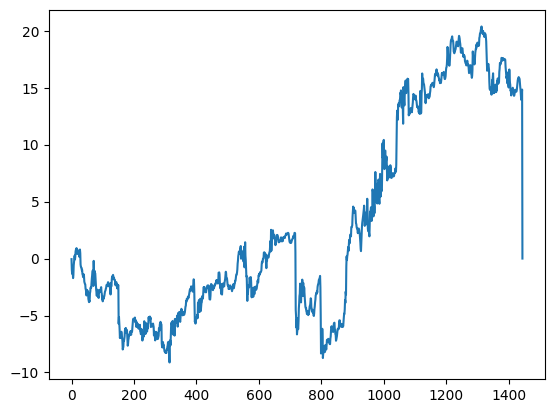

In [291]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt

# Wrap your environment in a vectorized environment (required by Stable-Baselines3)
#env = DummyVecEnv([lambda: StockHedgingEnv(df)])

def make_env():
    return StockHedgingEnv(df, render_mode='human')  # Specify the render_mode here

env = DummyVecEnv([make_env])

# Define the PPO model
#model = PPO('MlpPolicy', env, verbose=1)
model = PPO('MlpPolicy', env, verbose=1, n_epochs = 100)

# Train the model
model.learn(total_timesteps = 10000)

# Reset the environment to start a new episode
state = env.reset()

done = False
total_reward = 0

portfolio_value = []

while not done:
    # Get the action from the trained PPO model
    action, _ = model.predict(state)

    # Take the action in the environment
    state, reward, done, info = env.step(action)

    # Accumulate the total reward
    total_reward += reward

    # Render the environment
    env.render()
    #if isinstance(env.envs[0].render(), np.ndarray):

    #elif isinstance(env.envs[0].render(), np.float64):
    value = env.envs[0].render()
    portfolio_value.append(value)
    #env.envs[0].render()

print(f"Total Reward: {total_reward}")
plt.plot(portfolio_value)

In [259]:
env.envs[0].render()

Step: 10, Balance: 0, Option held: 0


0

In [211]:
isinstance(3, int)

True